In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops
import sampi

# Make toy problem

In [2]:
n_nonuniform = 100

y_uniform_true = jlinops.piecewise_constant_1d_test_problem()
n = len(y_uniform_true)
x_uniform = np.linspace(0, 1, n)
np.random.seed(0)
noise_stdev = 0.1
noise_var = noise_stdev**2
x_nonuniform = np.sort(np.random.uniform(low=1e-3, high=1.0 - 1e-3, size=n_nonuniform))

# make regridding op
regridding_op = jlinops.LinearNonuniform2Uniform1DGriddingOperator( (0,1), n, x_nonuniform)

# Generate a noisy observation
y_nonuniform = regridding_op.matvec(y_uniform_true) + noise_stdev*np.random.normal(size=n_nonuniform)

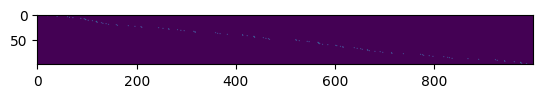

In [3]:
plt.imshow(regridding_op.regridding_mat.toarray())
plt.show()

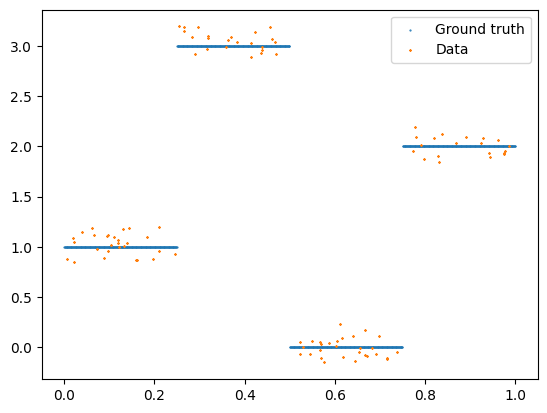

In [4]:
plt.scatter(x_uniform, y_uniform_true, label="Ground truth", color="C0", s=0.3)
plt.scatter(x_nonuniform, y_nonuniform, marker="x", label="Data", color="C1", alpha=1.0, s=1.2)
plt.legend()
plt.show()

In [5]:
# Define forward operator and regularization matrix
F = regridding_op
Rmat, Wmat = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)

In [6]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [7]:
# Prior parameters
reg_lambda = 2*1e2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-4,
    # }
}

# Create solver
solver = sampi.IASSolver(F, R, y_nonuniform, hyperparams, noise_var=noise_var, pdata=pdata)

In [8]:
data = solver.solve(max_iters=1000, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3)
y_uniform_recovered = data["x"]

In [9]:
data["n_iters"]

1000

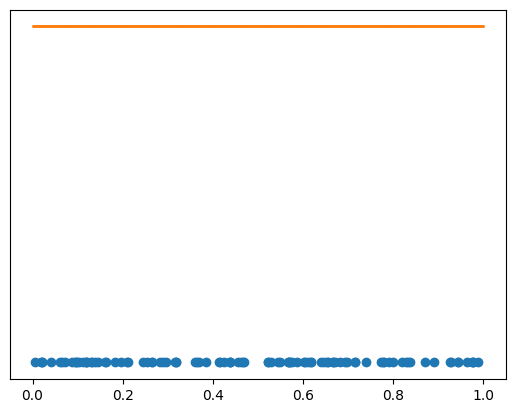

In [10]:
plt.scatter(x_nonuniform, np.ones_like(x_nonuniform), label="nonuniform gridpoints")
plt.scatter(x_uniform, 2*np.ones_like(x_uniform), s=0.5, label="uniform gridpoints")
plt.yticks([])
plt.show()

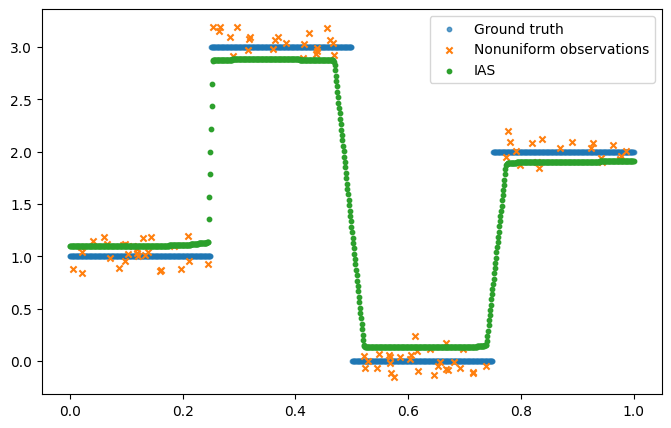

In [11]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, y_uniform_recovered, s=s, label="IAS")
plt.legend()
plt.show()

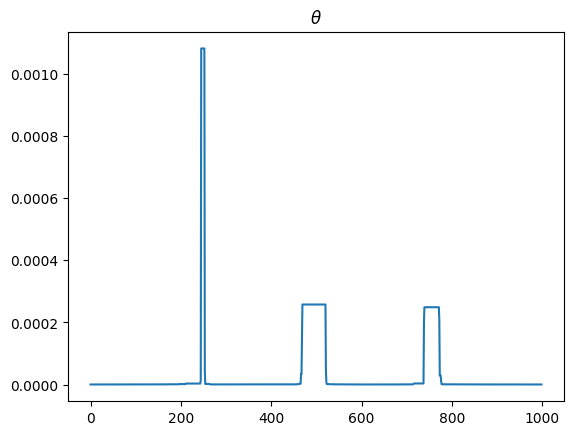

In [12]:
plt.plot(data["theta"])
plt.title("$\\theta$")
plt.show()

In [13]:
data["n_iters"]

1000

In [14]:
print(np.sum(data["n_cg_its_per_iteration"]))

122


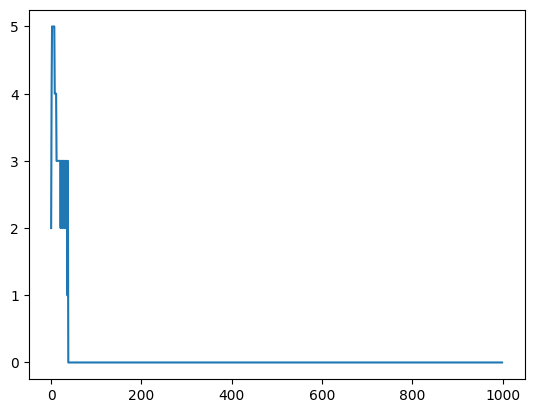

In [15]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

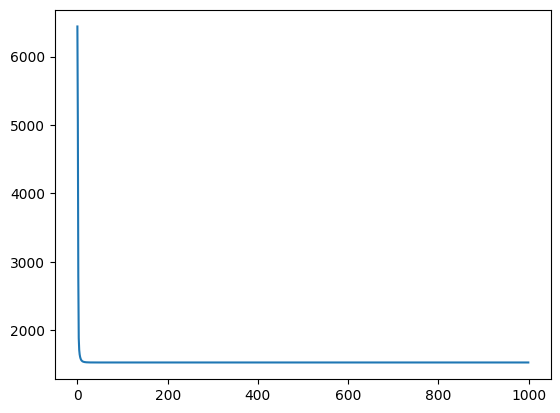

In [16]:
plt.plot(data["obj_vals"])
plt.show()

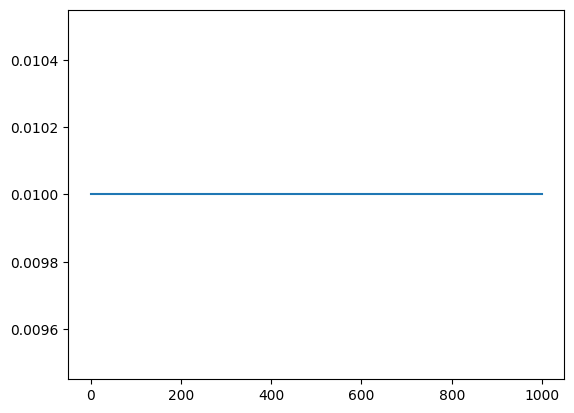

In [17]:
plt.plot(data["noise_vars"])
plt.show()

# Strongly sparsity promoting

In [18]:
# Prior parameters
# reg_lambda = 2*1e2
# vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": -1.0,
        "beta": 1.0,
        "vartheta": 1e-6,
    },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-4,
    # }
}

# Create solver
solver = sampi.IASSolver(F, R, y_nonuniform, hyperparams, noise_var=noise_var, pdata=pdata)

In [19]:
data = solver.solve(max_iters=1000, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3)
y_uniform_recovered = data["x"]

In [20]:
data["n_iters"]

1000

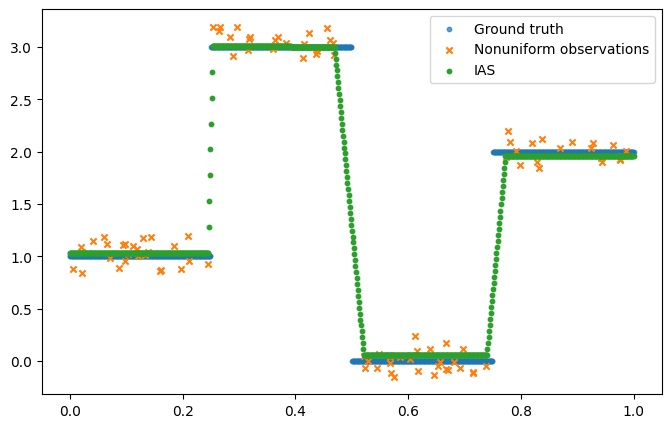

In [21]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, y_uniform_recovered, s=s, label="IAS")
plt.legend()
plt.show()

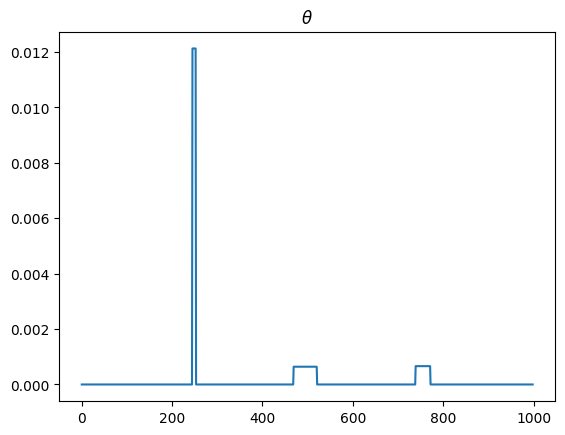

In [22]:
plt.plot(data["theta"])
plt.title("$\\theta$")
plt.show()

# With standard Gaussian prior?

In [40]:
lam = 5*1e3
gauss_data = jlinops.trlstsq((1.0/noise_stdev)*F, R, (1.0/noise_stdev)*y_nonuniform, lam=lam)

(1099,)


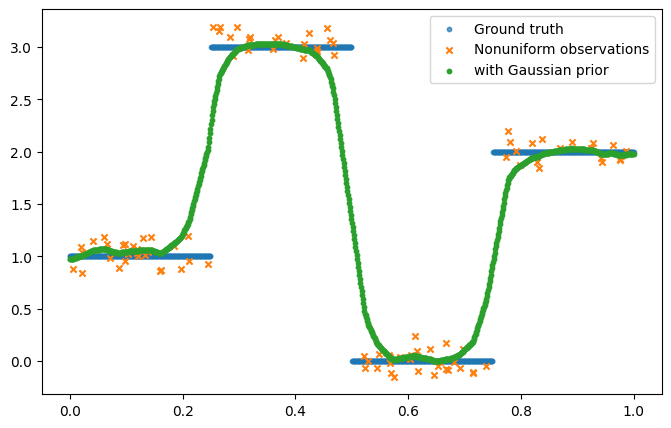

In [42]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, gauss_data["x"], s=s, label="with Gaussian prior")
plt.legend()
plt.show()